# This is the First Draft of Our Clustering Final Notebook

In [1]:
# Performing the many imports required to do the various analyses of this notebook:
import pandas as pd
import numpy as np
import os
from env import host, user, password
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import env
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
import scipy
import sklearn.linear_model
import sklearn.preprocessing
import warnings
warnings.filterwarnings("ignore")
import wrangle
import viz_explore
import brian_feature_engineering
import brian_model
import cluster_model
import scipy.stats as stats
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model
import sklearn.preprocessing
import warnings

In [2]:
# THE WRANGLE FUNCTION PERFORMS THE FOLLOWING, IN BROAD STROKES:
# 1. Get the data via SQL query
# 2. Clean and prep the data
# 3. Encode the appropriate columns (only ['county'] for now)
# 4. Split the data: train, validate, test and X_ vs y_ splits as well
# 5. Scale the data (all train, validate and test, and all X_ and y_ splits are scaled)

df, train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test, \
train_scaled, X_train_scaled, y_train_scaled, validate_scaled, X_validate_scaled, \
y_validate_scaled, test_scaled, X_test_scaled, y_test_scaled \
= wrangle.wrangle_zillow()

# Exploration: univariate

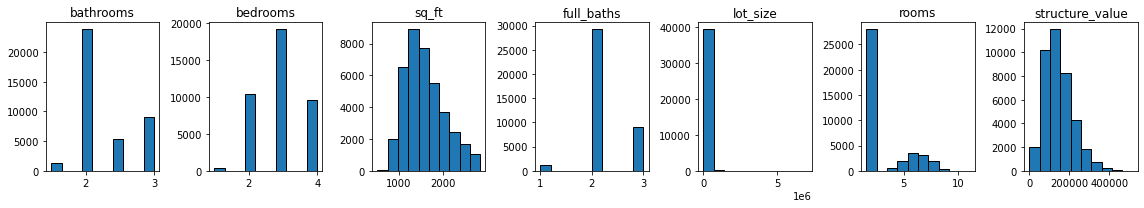

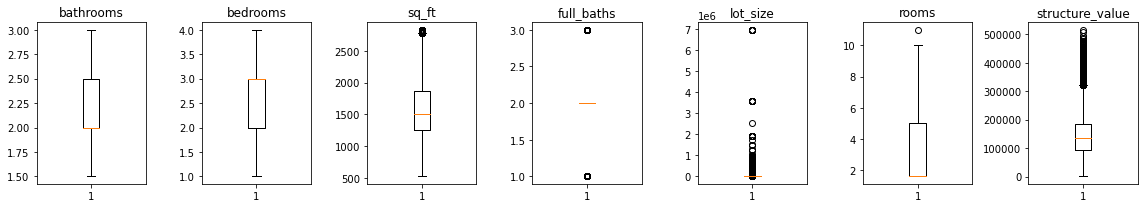

In [3]:
# The following four cells call a function in our viz_explore script to visualize histogrmas and boxplots
# for all the features left in the main dataframe.
viz_explore.histograms1(df)

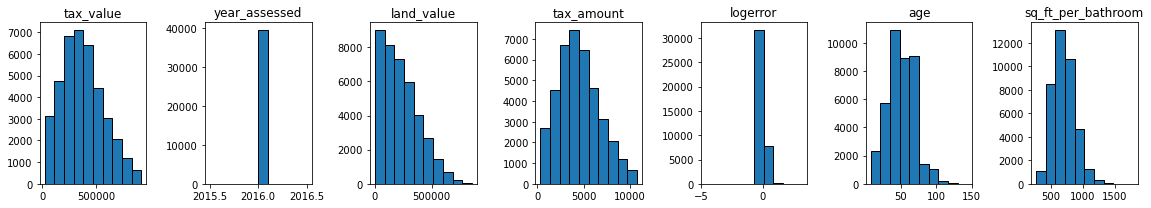

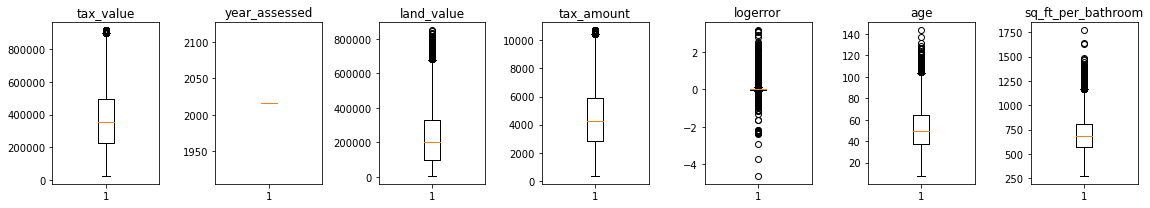

In [4]:
viz_explore.hists2(df)

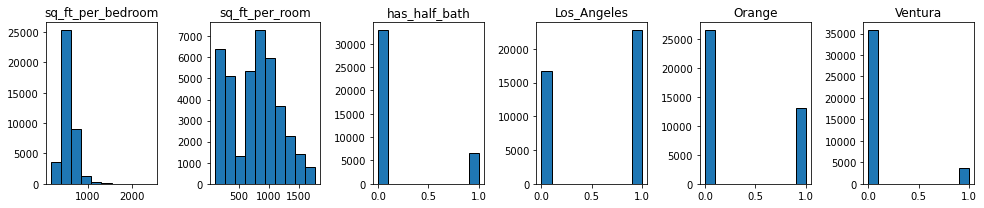

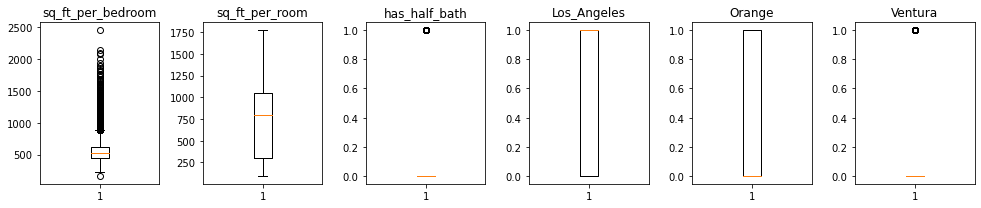

In [5]:
viz_explore.hists3(df)

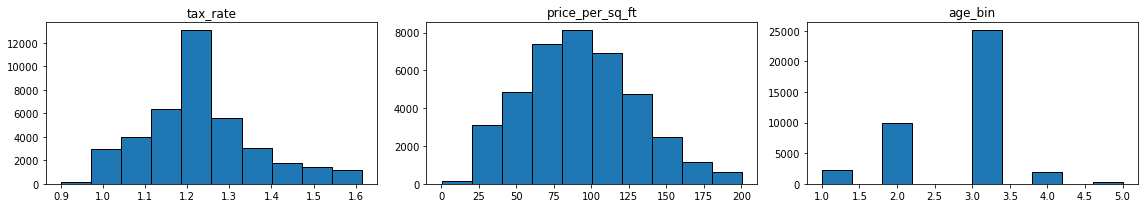

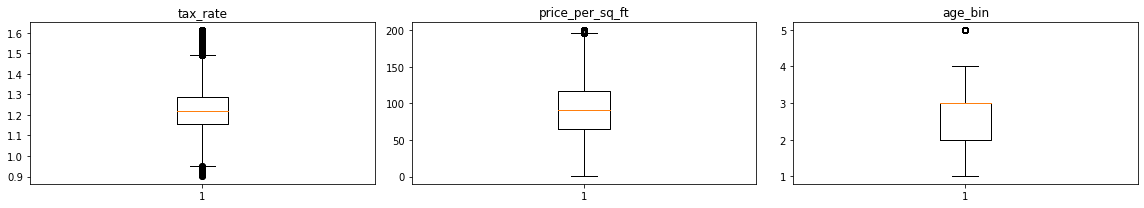

In [6]:
viz_explore.hists4(df)

- The main standouts here are the number of rooms, which has a considerable right skew (also, all homes that had previously had "zero" rooms were imputed to the mean), as well as the many outliers in certain attributes, which have been left even after applying a "remove_outliers" function in the wrangle module.

### Exploration question 1:

### Is there a time period that has a higher or lower log error?

<AxesSubplot:xlabel='age', ylabel='logerror'>

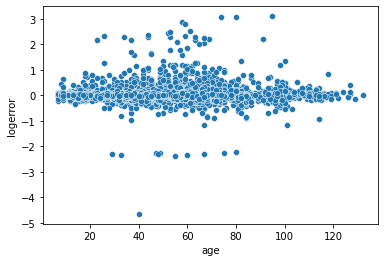

In [7]:
# A seaborn scatterplot comparing age to logerror
sns.scatterplot(x='age', y='logerror', data=train)

- There are a few outliers on logerror in the middle of the ages (less so on the extreme age values). Still, not exactly tons of them, considering the number of rows we have.

<AxesSubplot:xlabel='age_bin', ylabel='logerror'>

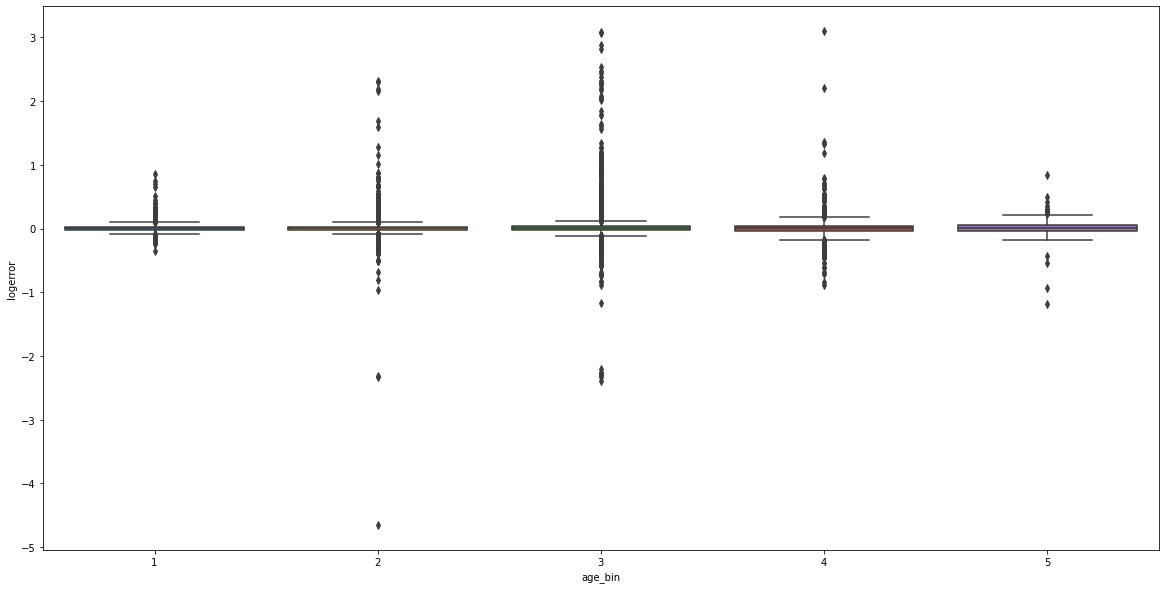

In [8]:
# Here, I draw up a cell with the boxplot of logerror for each age bin

plt.figure(figsize=(20,10))
sns.boxplot(x='age_bin', y='logerror', data= train)

- As can be seen again, there are more outliers in the middle. Also, this could be due to more data being available in those age bins

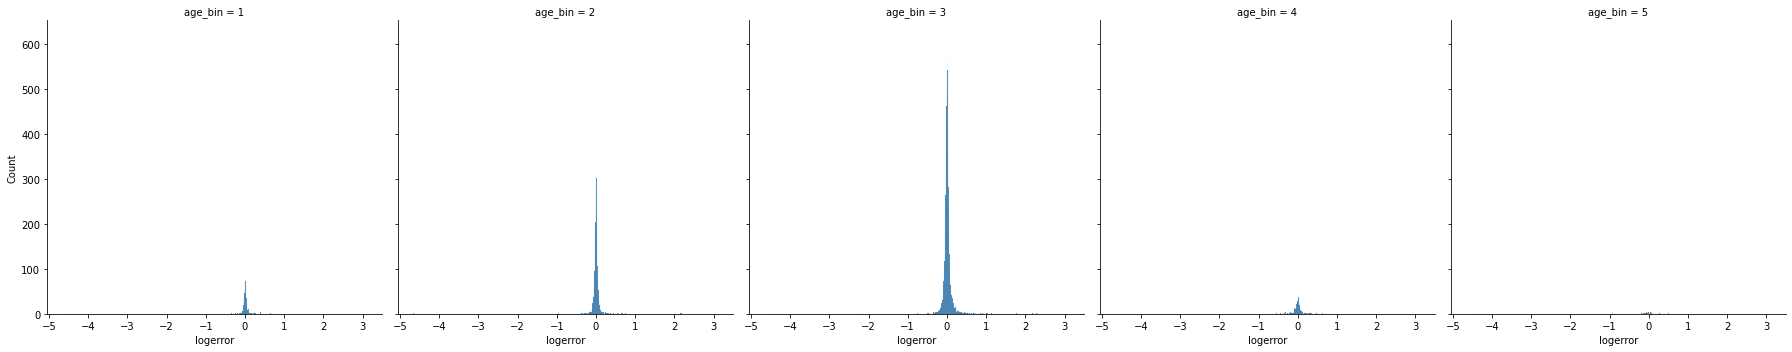

In [9]:
# The following seaborn displot demonstrates the normality of the logerror by age_bin, for statistical testing
sns.displot(x= train.logerror, col=train.age_bin)

- Looking at logerror by age_bin, they are generally normally distributed

### Statistical testing:

- First, I run a Levene test to check the age_bins' variances

- Hypotheses:
    - H0: Variances are equal
    - Ha: Variances are not equal

In [10]:
# This cell runs a levene test on the logerror of the age bins

stats.levene(
    train[train.age_bin == 1].logerror,
    train[train.age_bin == 2].logerror,
    train[train.age_bin == 3].logerror,
    train[train.age_bin == 4].logerror,
    train[train.age_bin == 5].logerror,
)

LeveneResult(statistic=35.691437225453534, pvalue=9.018828129647642e-30)

- The results show that the null hypothesis is rejected

#### Anova testing of the logerror by age_bin

Set Hypotheses
- 𝐻0 : Population means of logerror (by age_bin) are equal
- 𝐻𝑎 : Population means of logerror (by age_bin) are not all equal

In [11]:
# This cell runs an ANOVA test on the different 'age_bins'
# We are demonstrating statistically that the age correlates to the logerror
f, p = stats.f_oneway(
    train[train.age_bin == 1].logerror,
    train[train.age_bin == 2].logerror,
    train[train.age_bin == 3].logerror,
    train[train.age_bin == 4].logerror,
    train[train.age_bin == 5].logerror,)
f, p

(4.0670874591621695, 0.0026856813799192914)

In [12]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha
# to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


#### The anova test shows I can proceed with the understanding that the average logerror is different depending on the age of the home

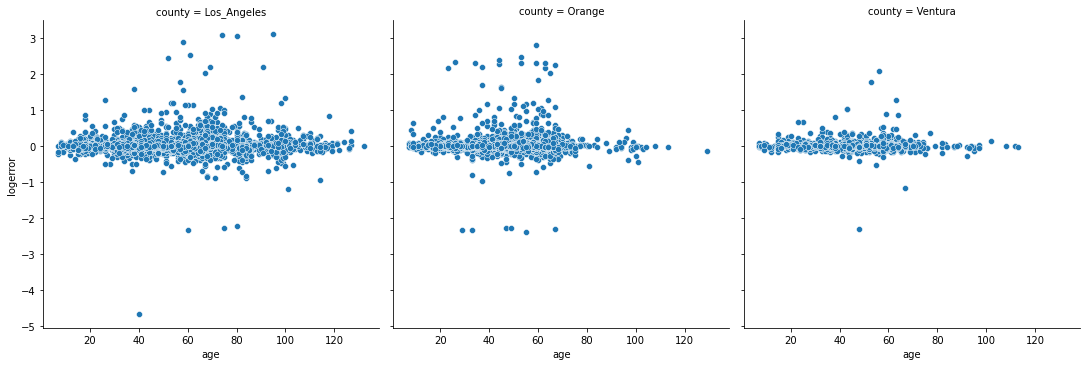

In [13]:
# Here, we check on the logerror by age, split by county, using a seaborn relplot
sns.relplot(data=train, y='logerror', x='age', col='county')

- There seems to be more logerror in Los_Angeles county than in Orange, and even less in Ventura.  
- The variance in the logerror by age for Ventura county also seems lower

In [14]:
# A quick comparison of the variance of logerror by age by county:
counties = ['Los_Angeles', 'Orange', 'Ventura']
for i in counties:
    print(train.logerror[train.county == i].var())    

0.02012712794590743
0.026176198304487853
0.015015625114290707


- As can be seen, the variance in logerror does in fact differ from county to county

### Exploration answer 1:
- There is a small amount of difference in the logerror for middle-aged homes.  Possibly helpful for modeliing

### Exploration question 2:

- What about a relationship between tax_value and logerror?

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

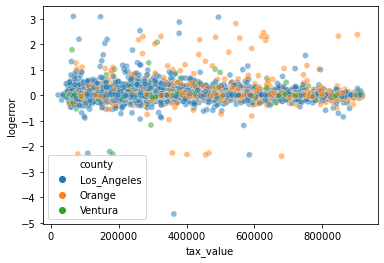

In [15]:
# A seaborn scatterplot of the two variables, hued by county
sns.scatterplot(x=train.tax_value, y=train.logerror, data=train, hue='county', alpha=.5)

- Not a lot to go on here but a few outliers in all the counties

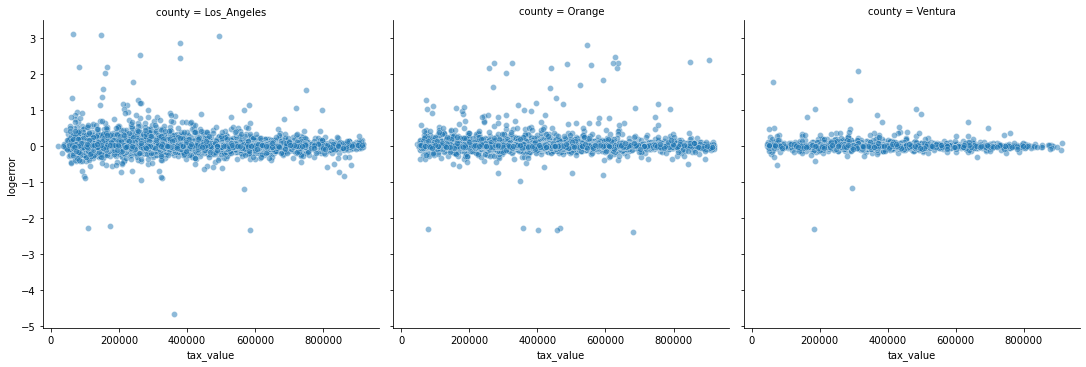

In [16]:
# The same, but divide up by col instead of hue.  
sns.relplot(x=train.tax_value, y=train.logerror, data=train, col='county', alpha=.5)

- Perhaps the variances are different as they were in the exploration of age/logerror.  Not an area to pursue

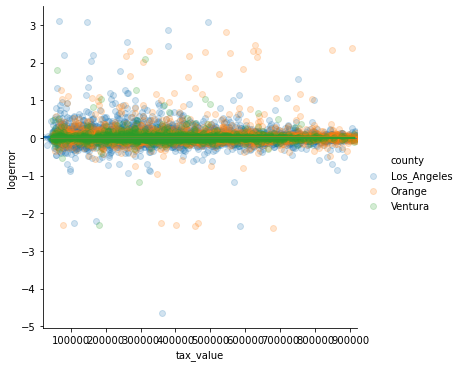

In [17]:
# A seaborn lmplot to visualize the trendlines of the logerror by tax_value/county
sns.lmplot(x='tax_value', y='logerror', data=train, scatter_kws={'alpha':.2},hue='county')

- They look like perfectly flat trend lines

### Exploration answer 2:

- No clear impressions

### Exploration question 3:
- Does the condition of the home have an impact on the logerror?

<AxesSubplot:xlabel='condition', ylabel='logerror'>

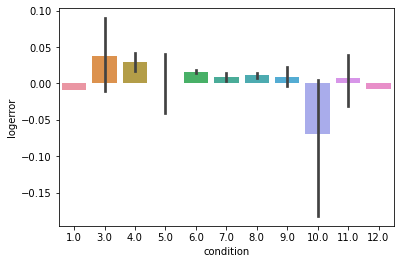

In [18]:
# A seaborn barplot to vizualize the logerror of the different house 'conditions'
sns.barplot(x=train.condition,y=train.logerror, data=train)

- The logerror is off by more on the houses with a condition of 10 and 3

### An ANOVA test is in order to show this:

First, a Levene test to check on variances:

- Hypotheses:
    - #H0: Variances are equal
    - #Ha: Variances are not equal

<AxesSubplot:>

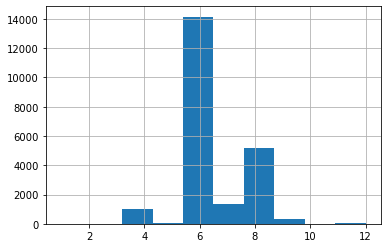

In [19]:
train['condition'].hist()

- The house conditions are roughly normally distributed

In [20]:
# Levene test for equal variances...they aren't equal
stats.levene(train.condition==1,train.condition==3,train.condition==4,train.condition==5,
            train.condition==6,train.condition==7,train.condition==8,train.condition==9,
            train.condition==10, train.condition==11,train.condition==12)

LeveneResult(statistic=6602.5022161121415, pvalue=0.0)

Set Hypothesis (for the ANOVA test)
- 𝐻0 : Population means of logerror (by condition) are equal
- 𝐻𝑎 : Population means of logerror (by condition) are not all equal

In [21]:
# the anova test:
f, p = stats.f_oneway(train.condition==1,train.condition==3,train.condition==4,train.condition==5,
            train.condition==6,train.condition==7,train.condition==8,train.condition==9,
            train.condition==10, train.condition==11,train.condition==12)
f,p

(17326.94526429442, 0.0)

In [22]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We reject H_O


### Exploration answer 3:
- the condition of a home does in fact bear on its logerror

### Exploration question 4:
- How does logerror differ from one county to the next?

<AxesSubplot:xlabel='county', ylabel='logerror'>

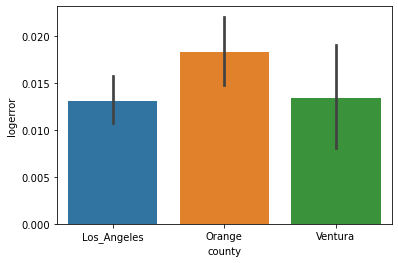

In [23]:
# Seaborn barplot of the logerrors; a boxplot was not visually helpful
sns.barplot(x=train.county, y=train.logerror)

### Running an Kruskal-wallace to check on this

H_0: Average logerror of the three counties is the same


H_a: The logerror is different according to county

- It was shown above that the logerror by county has different variances, so

In [24]:
f,p = scipy.stats.kruskal(train.logerror[train.county == 'Los_Angeles'],\
                          train.logerror[train.county == 'Orange'],\
                          train.logerror[train.county == 'Ventura'],nan_policy='propagate')
f,p

(4.081862375625654, 0.12990768608468994)

In [25]:
# Setting our alpha and returning a statemtent on the validity of the ANOVA test by comparing alpha to the resulting p-value

alpha = 0.05
if p < alpha:
    print("We reject H_O")
else:
    print("We fail to reject $H_{0}$")

We fail to reject $H_{0}$


- The kruskal-wallace statistical test did not show that there is a significant difference in the logerrors of the different counties

### Exploration answer 4:
- There is not enough evidence to understand the logerror differs significantly from one county to another.

### Exploration question 5:
- Does having a half bathroom make a difference for logerror?

<AxesSubplot:xlabel='has_half_bath', ylabel='logerror'>

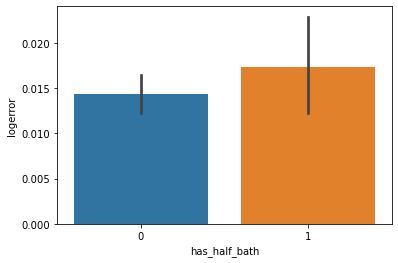

In [26]:
# A barplot showing the difference in logerror for has_half_bath or not.
sns.barplot(x=train.has_half_bath,y=train.logerror)

- There is some difference, but not a lot...proceeding to stats testing via one sided, independent t test

First: assumptions:

- Normally distributed...basically yes and many observations
- Independence: check
- Variances...are almost equal actually


<AxesSubplot:>

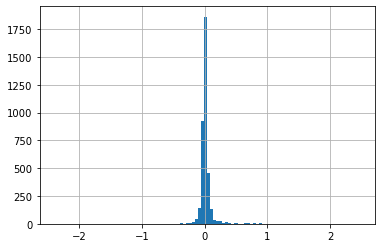

In [27]:
# This cell shows a histogram of the logerror of those homes that have a half bathroom
has_half_bath_sample = train[train.has_half_bath == 1].logerror

has_half_bath_sample.hist(bins=100)

- Note how there are some examples that are wildly off in their logerror

In [28]:
# And its variance:
has_half_bath_sample.var()

0.024895170440781326

<AxesSubplot:>

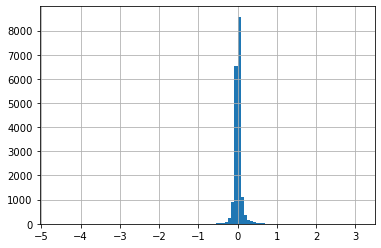

In [29]:
# The same, but for no half baths:
no_half_bath_sample = train[train.has_half_bath==0].logerror
no_half_bath_sample.hist(bins=100)

In [30]:
no_half_bath_sample.var()

0.020985347019266413

Set Hypothesis

H_0
: Mean of logerror of has_half_bath = Mean of logerror of no_half_bath

H_a
: Mean of logerror of has_half_bath != Mean of logerror of no_half_bath

In [31]:
t, p = stats.ttest_ind(has_half_bath_sample, no_half_bath_sample, equal_var=False)

t, p

(1.0449975638488767, 0.29607360629596075)

- p is NOT less than alpha (0.05), and therefore the Null Hypothesis cannot be rejected

### Exploration answer 5:
- So, having a half bathroom does not affect logerror.  Not directly for sure

## Exploration Summary:
- Of the five questions answered, my statistical tests and/or visuals rebuffed a full 3 of them as significant for logerror.
- Age and condition are two attributes that may be useful in modelling

# CLUSTERING

### I am clustering on the following attributes:
- sq_ft, price_per_sq_ft, tax_rate

### Conducting some elementary exploration of the target variables for the deal_or_not cluster

In [32]:
# define independent variables for k-means

deal_cluster_df = X_train_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]

- The deal_cluster_df is already scaled

array([[<AxesSubplot:title={'center':'sq_ft'}>,
        <AxesSubplot:title={'center':'price_per_sq_ft'}>],
       [<AxesSubplot:title={'center':'tax_rate'}>, <AxesSubplot:>]],
      dtype=object)

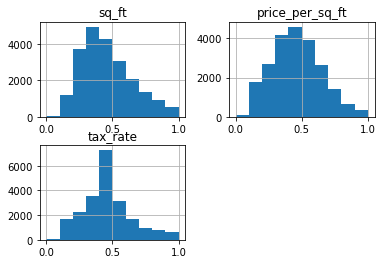

In [33]:
deal_cluster_df.hist()

<AxesSubplot:>

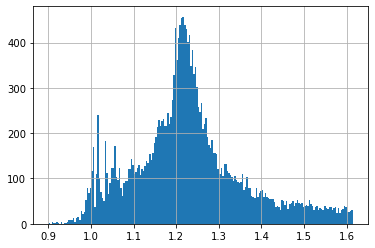

In [34]:
# A histogram of the tax rates
train.tax_rate.hist(bins=200)
# I have removed all tax rates above 5%, of which there were only 38

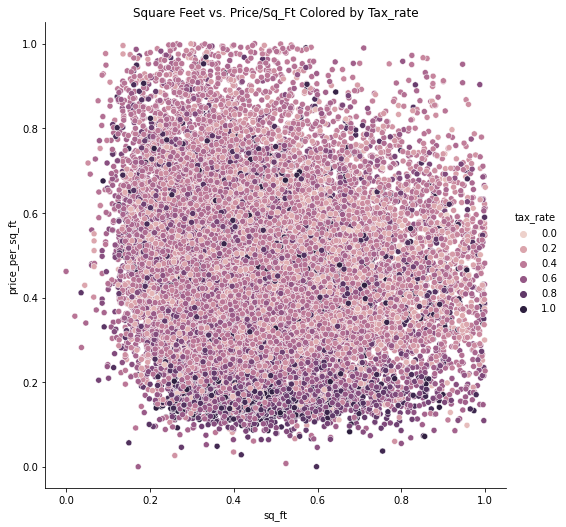

In [35]:
# A relplot of the relationship between sq_ft and price_per_sq_ft, hued on tax rate
sns.relplot(data=train_scaled, x="sq_ft", y="price_per_sq_ft", hue='tax_rate', height=7, \
            aspect=1).set(title="Square Feet vs. Price/Sq_Ft Colored by Tax_rate")


- I see more of the higher tax rate homes toward the lower end of the ppsf axis (algthough the density of data makes it hard to be sure)

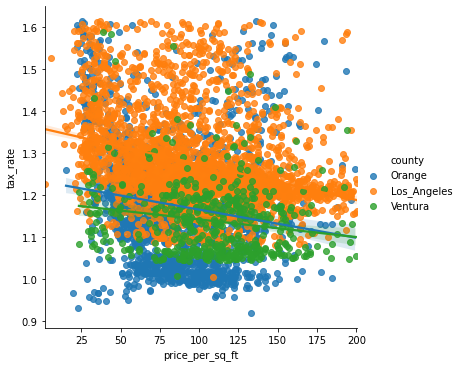

In [36]:
# PPSF vs tax_rate, by county
sns.lmplot(x='price_per_sq_ft', y='tax_rate', data=train.sample(5000), hue='county')

- The trend lines are awfully similar, though with a higher tax rate in LA county

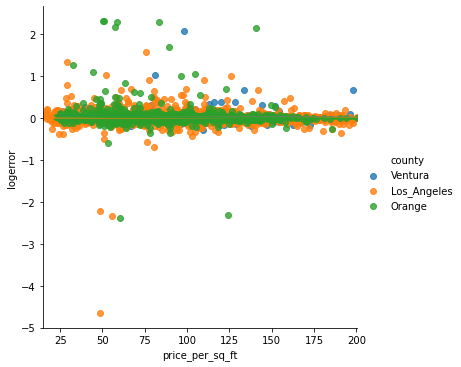

In [37]:
# PPSF vs logerror by county
sns.lmplot(x='price_per_sq_ft', y='logerror', data=train.sample(5000), hue='county')

- Not a lot to be gleaned here

### We ran a find_kmeans function to determine the optimal value for k, which is defined in the folowing cell:

In [38]:
k = 5

In [39]:
from sklearn.cluster import KMeans
# sklearn implementation of KMeans

#define the thing
kmeans_deal_cluster_df = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans_deal_cluster_df.fit(deal_cluster_df)

# Use (predict using) the thing 
kmeans_deal_cluster_df.predict(deal_cluster_df)

array([0, 4, 0, ..., 1, 3, 4], dtype=int32)

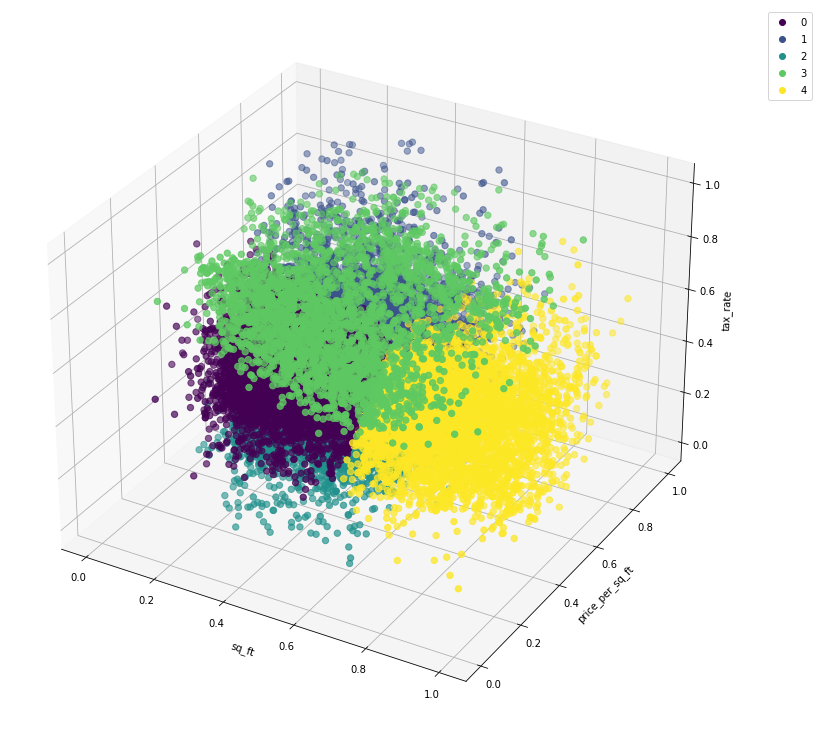

In [40]:
import re, seaborn as sns
import numpy as np
# from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# The following command will make the graphic interactive
# but it creates problems for subsequent graphics and should be commented out 
# until it's being used

# %matplotlib notebook

# assigning the graphing data
x = deal_cluster_df.sq_ft
y = deal_cluster_df.price_per_sq_ft
z = deal_cluster_df.tax_rate
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
fig.add_axes(ax)
# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
t = kmeans_deal_cluster_df.predict(deal_cluster_df)
# plot
# the x,y,z labels might need to be specific...
sc = ax.scatter(x, y, z, s=40, c=t, marker='o')#, cmap=t, alpha=1)
ax.set_xlabel('sq_ft')
ax.set_ylabel('price_per_sq_ft')
ax.set_zlabel('tax_rate')
# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
# plt.savefig("scatter_hue", bbox_inches='tight')

In [41]:
# make a new column names cluster in iris and X_scaled dataframe

X_train_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)
train['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)
deal_cluster_df['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df)

In [42]:
# Code to give names to the different deal_clusters:
train['deal_cluster'] = np.where(train.deal_cluster == 0,'large_homes',np.where(train.deal_cluster == 1,'small_to_med_cheaper'\
            ,np.where(train.deal_cluster == 2, 'small_cheap_lowtax',np.where(train.deal_cluster == 3,'small_expensive'\
            ,'small_cheap_midtax'))))

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

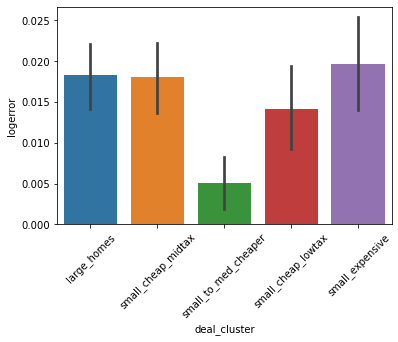

In [43]:
# A seaborn barplot to quickly check logerror by cluster
sns.barplot(x='deal_cluster',y='logerror',data=train)
plt.xticks(rotation=45)
plt.tight_layout

- As can be seen, the small_to_med_cheaper cluster has relatively low logerror

<AxesSubplot:xlabel='county', ylabel='logerror'>

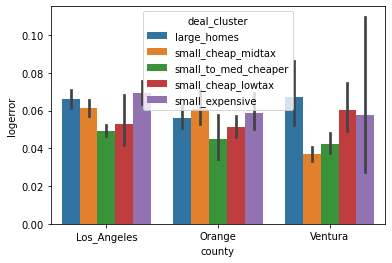

In [44]:
# Checking the logerror of the clusters by county
sns.barplot(x='county',y=df['logerror'].abs(),data=train,hue='deal_cluster')

- The small_cheap_midtax cluster has a lower logerror in Ventura county. Maybe evidence to use different modeling on that county?

### ANOVA testing is called for to establish that every cluster has a different logerror

-Set Hypotheses

    - 𝐻0 : Population means of logerror (by cluster) counts are equal
    - 𝐻𝑎 : Population means of logerror (by cluster) are not all equal

In [45]:
# This cell runs an ANOVA test on the different deal_clusters
f, p = stats.f_oneway(train[train.deal_cluster == 'large_homes'].logerror,train[train.deal_cluster == 'small_to_med_cheaper'].logerror,\
                      train[train.deal_cluster == 'small_cheap_midtax'].logerror, train[train.deal_cluster == 'small_cheap_lowtax'].logerror,\
                      train[train.deal_cluster == 'small_expensive'].logerror)
f, p

(7.706662023606853, 3.3524353033198495e-06)

- The miniscule pvalue shows that the logerror of the different clusters is clearly different

#  MODELING

### Scaling
-We have done modeling on the scaled datasets (both X_train and y_train, etc.)

### Baseline
- We will use MEAN as the baseline

### Features
- We will define kbest and rfe features below
- All the X_train_scaled, X_validate_scaled, etc. are scaled from X_train, etc.¶
- All of the X_train_kbest, X_train_rfe, etc are derived from the scaled datasets

In [46]:
# This cell runs my function in feature_engineering.py that selects for the top 'k' number 
# of features
f_feature = brian_feature_engineering.select_kbest(X_train_scaled,y_train_scaled, 5)
f_feature

['bedrooms', 'condition', 'rooms', 'tax_amount', 'price_per_sq_ft']

In [47]:
# Likewise, here we are using a function from the feature_engineering.py file to select for the best RFE features

rfe_feature = brian_feature_engineering.select_rfe(X_train_scaled,y_train_scaled, 5)
rfe_feature

['condition',
 'lot_size',
 'structure_value',
 'sq_ft_per_bathroom',
 'price_per_sq_ft']

## First, we are going to run modeling on just the deal_clusters and have a look at the results

### The next cell establishes baseline as a starting point:

In [48]:
# 1. Predict logerror_pred_mean
# I create here new columns in the y_ data sets to hold the baseline value I am working with.
logerror_pred_mean = y_train_scaled.logerror.mean()
y_train_scaled['logerror_pred_mean'] = round(logerror_pred_mean, 5)
y_validate_scaled['logerror_pred_mean'] = round(logerror_pred_mean,5)
y_test_scaled['logerror_pred_mean'] = round(logerror_pred_mean,5)

# 2. RMSE of logerror_pred_mean
# Here, I calculate the Root Mean Squared Error of the baseline and print it
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train_scaled.logerror,
                                y_train_scaled.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_scaled.logerror, y_validate_scaled.logerror_pred_mean) ** (0.5)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

RMSE using Mean
Train/In-Sample:  0.01897 
Validate/Out-of-Sample:  0.01899


In [49]:
# Here, I create a DataFrame to insert the evaluation metrics of the different models; this datafram will be 
# taken in by the modeling function below and expanded on.
metric_df = pd.DataFrame(data=[
            {
                'model': 'mean_baseline', 
                'RMSE_train': rmse_train,
                'RMSE_validate': rmse_validate
                }
            ])
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994


In [50]:
deal_cluster_df_train = X_train_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]
deal_cluster_df_validate = X_validate_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]
deal_cluster_df_test = X_test_scaled[['sq_ft', 'price_per_sq_ft', 'tax_rate']]

In [51]:
# sklearn implementation of KMeans

#define the thing
kmeans_deal_cluster_df = KMeans(n_clusters=5, random_state = 123, verbose = 0)

# fit the thing
kmeans_deal_cluster_df.fit(deal_cluster_df_train)

# Use (predict using) the thing 
kmeans_deal_cluster_df.predict(deal_cluster_df_train)

array([0, 4, 0, ..., 1, 3, 4], dtype=int32)

- Adding a cluster column to each pertinent df

In [52]:
X_train_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_train)
X_train_scaled['deal_cluster'] = np.where(X_train_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_train_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_train_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_train_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))




In [53]:
X_validate_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_validate)
X_validate_scaled['deal_cluster'] = np.where(X_validate_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_validate_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_validate_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_validate_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))



In [54]:
X_test_scaled['deal_cluster'] = kmeans_deal_cluster_df.predict(deal_cluster_df_test)
X_test_scaled['deal_cluster'] = np.where(X_test_scaled.deal_cluster == 0,'large_homes',np.where(\
                                X_test_scaled.deal_cluster == 1,'small_to_med_cheaper',\
                                np.where(X_test_scaled.deal_cluster == 2, 'small_cheap_lowtax',\
                                np.where(X_test_scaled.deal_cluster == 3,'small_expensive','small_cheap_midtax'))))




- Encoding the clusters onto the respective dfs

In [56]:
X_train_scaled = cluster_model.encode_clusters(X_train_scaled,['deal_cluster'])
X_validate_scaled = cluster_model.encode_clusters(X_validate_scaled,['deal_cluster'])
X_test_scaled = cluster_model.encode_clusters(X_test_scaled,['deal_cluster'])

In [57]:
kbest_vars = ['deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper']
rfe_vars = ['deal_cluster_large_homes',
       'deal_cluster_small_cheap_lowtax', 'deal_cluster_small_cheap_midtax',
       'deal_cluster_small_expensive', 'deal_cluster_small_to_med_cheaper']

X_train_kbest, X_validate_kbest, X_test_kbest, X_train_rfe, X_validate_rfe, X_test_rfe = \
brian_model.create_data_for_models_including_clusters(X_train_scaled, X_validate_scaled, X_test_scaled,\
kbest_vars, rfe_vars)

In [58]:
metric_df = brian_model.run_all_models_on_all_data(X_train_kbest, y_train_scaled, X_validate_kbest, y_validate_scaled, X_train_rfe, X_validate_rfe, X_test_kbest, X_test_rfe, metric_df)

In [59]:
metric_df

,model,RMSE_train,RMSE_validate
0,mean_baseline,0.018968,0.018994
1,OLS Regressor KBEST,0.018955,0.018994
2,OLS Regressor RFE,0.018955,0.018994
3,Lasso_alpha1_KBEST,0.018968,0.018994
4,Lasso_alpha1_RFE,0.018968,0.018994
5,glm_compound_kbest,0.018955,0.018994
6,glm_compound_rfe,0.018955,0.018994
7,quadratic_kbest,0.018955,0.018995
8,quadratic_rfe,0.018955,0.018995


- Note that the kbest and rfe features are identical in this code--for expediency, I have not (yet) changed the code for running clusters only, and therefore the results between "kbest" features and "rfe" features are identical (they're the same features). I future iteration of the project will address this.

- Takeaway: running the models on the clusters only yields a slightly better-than-baseline result, but barely. And the kbest features above (which do actually include one of the clusters) yielded the best results when run on the glm_compound_kbest model (without significant difference to the validate results--the quadratic model run on kbest did return better results on train, but worse on validate, and I am therefore rejecting it).

## THE DRAFT IS ALMOST DONE, JUST NEED TO RUN F.E. ON ALL ATTRIBUTES AND MODEL ON THE RESULTING FEATURES